### DNN

### Import libraries

In [1]:
!pip install optuna

import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.models import Model
import optuna
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.5/599.5 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### Preprocessing module

In [2]:
# Load the data
train_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv'
test_url = 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv'

train_df = pd.read_csv(train_url, header=None)
test_df = pd.read_csv(test_url, header=None)
train_df.columns = ['Class Index', 'Title', 'Description']
test_df.columns = ['Class Index', 'Title', 'Description']

In [3]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower() # convert text to lowercase
    text = re.sub(r'\b(u\.s\.|us)\b', 'usa', text, flags=re.IGNORECASE)  # replace "U.S." or "US" with "usa"
    text = re.sub(r'<[^>]+>', '', text)  # remove HTML tags
    text = re.sub(r'&\w+;', '', text)  # remove HTML entities
    text = re.sub(r'[^a-z\s]', '', text)  # remove numbers and punctuation (keep only letters and spaces)
    words = text.split()
    words = [word for word in words if word not in stop_words] # remove stop-words, tokenization
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return ' '.join(words) # combining words into a string

# Applying preprocessing
train_df['clean_text'] = (train_df['Title'] + ' ' + train_df['Description']).apply(preprocess_text)
test_df['clean_text'] = (test_df['Title'] + ' ' + test_df['Description']).apply(preprocess_text)

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['clean_text'])

# Prepare padded sequences for titles and descriptions
max_length_titles = max([len(x.split()) for x in train_df['Title']])
max_length_descriptions = max([len(x.split()) for x in train_df['Description']])

X_train_title_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Title']), maxlen=max_length_titles)
X_test_title_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Title']), maxlen=max_length_titles)

X_train_description_pad = pad_sequences(tokenizer.texts_to_sequences(train_df['Description']), maxlen=max_length_descriptions)
X_test_description_pad = pad_sequences(tokenizer.texts_to_sequences(test_df['Description']), maxlen=max_length_descriptions)

# Prepare labels
y_train = train_df['Class Index'].values - 1  # Adjust indices to [0, 1, 2, 3]
y_test = test_df['Class Index'].values - 1

from google.colab import drive
drive.mount('/content/drive')

# Load GloVe embeddings
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((5000, 100))
for word, i in tokenizer.word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(input_dim=5000, output_dim=100, weights=[embedding_matrix], trainable=False)

Mounted at /content/drive


### Bacic training module

In [4]:
# Build baseline model
title_input = Input(shape=(max_length_titles,), name='title_input')
title_embedding = embedding_layer(title_input)
title_flatten = Flatten()(title_embedding)

description_input = Input(shape=(max_length_descriptions,), name='description_input')
description_embedding = embedding_layer(description_input)
description_flatten = Flatten()(description_embedding)

merged = Concatenate()([title_flatten, description_flatten])

dense_1 = Dense(128, activation='relu')(merged)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(4, activation='softmax')(dense_2)

model = Model(inputs=[title_input, description_input], outputs=output)

model.compile(optimizer=Adam(learning_rate=3e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train baseline model
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1,
          epochs=5, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/5
3375/3375 [==============================] - 28s 8ms/step - loss: 0.4269 - accuracy: 0.8591 - val_loss: 0.3492 - val_accuracy: 0.8752
Epoch 2/5
3375/3375 [==============================] - 27s 8ms/step - loss: 0.3264 - accuracy: 0.8871 - val_loss: 0.3508 - val_accuracy: 0.8769
Epoch 3/5
3375/3375 [==============================] - 27s 8ms/step - loss: 0.3011 - accuracy: 0.8948 - val_loss: 0.3351 - val_accuracy: 0.8796
Epoch 4/5
3375/3375 [==============================] - 27s 8ms/step - loss: 0.2825 - accuracy: 0.9011 - val_loss: 0.3332 - val_accuracy: 0.8802
Epoch 5/5
3375/3375 [==============================] - 26s 8ms/step - loss: 0.2671 - accuracy: 0.9063 - val_loss: 0.3388 - val_accuracy: 0.8795


### Testing Module 1 (Base Model)

238/238 [==============================] - 1s 3ms/step
Baseline Test Accuracy: 0.8818
Baseline Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1900
           1       0.94      0.96      0.95      1900
           2       0.86      0.81      0.83      1900
           3       0.83      0.87      0.85      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



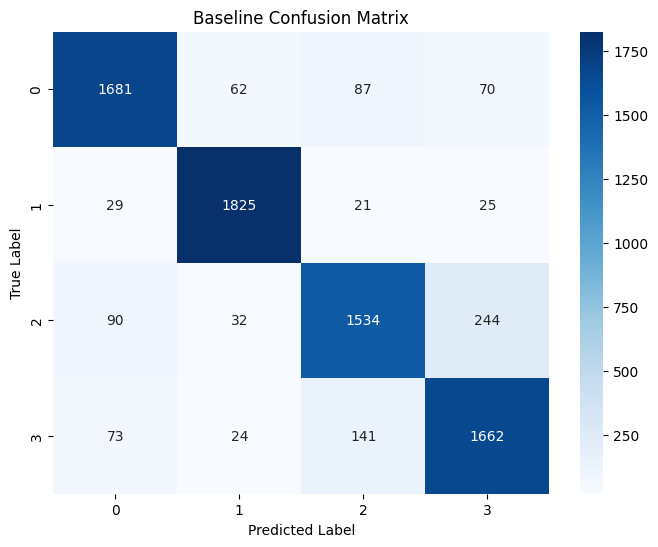

In [5]:
# Test the baseline model
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

baseline_accuracy = (y_pred_classes == y_test).mean()
print(f'Baseline Test Accuracy: {baseline_accuracy:.4f}')
print("Baseline Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Baseline Confusion Matrix')
plt.show()

### Hyperparameter selection module

In [6]:
def model_builder(trial):
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    num_units = trial.suggest_int('num_units', 64, 512)

    title_input = Input(shape=(max_length_titles,), name='title_input')
    title_embedding = embedding_layer(title_input)
    title_flatten = Flatten()(title_embedding)

    description_input = Input(shape=(max_length_descriptions,), name='description_input')
    description_embedding = embedding_layer(description_input)
    description_flatten = Flatten()(description_embedding)

    merged = Concatenate()([title_flatten, description_flatten])
    dense_1 = Dense(num_units, activation='relu')(merged)
    dropout_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(4, activation='softmax')(dropout_1)

    model = Model(inputs=[title_input, description_input], outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def objective(trial):
    model = model_builder(trial)
    model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=3, batch_size=32, verbose=1)
    _, accuracy = model.evaluate([X_test_title_pad, X_test_description_pad], y_test, verbose=1)
    return accuracy

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)
print("Best Trial:", study.best_trial)

[I 2024-10-29 18:51:34,331] A new study created in memory with name: no-name-b6a843f1-0c2f-42d3-8621-1f964295f6af


Epoch 1/3
3375/3375 [==============================] - 126s 37ms/step - loss: 0.3783 - accuracy: 0.8679 - val_loss: 0.3315 - val_accuracy: 0.8823
Epoch 2/3
3375/3375 [==============================] - 121s 36ms/step - loss: 0.2998 - accuracy: 0.8937 - val_loss: 0.3263 - val_accuracy: 0.8829
Epoch 3/3
238/238 [==============================] - 1s 4ms/step - loss: 0.3232 - accuracy: 0.8866


[I 2024-10-29 18:57:45,162] Trial 0 finished with value: 0.8865789771080017 and parameters: {'dropout_rate': 0.368969973598992, 'learning_rate': 0.0001423042479458088, 'num_units': 471}. Best is trial 0 with value: 0.8865789771080017.


Epoch 1/3
3375/3375 [==============================] - 47s 14ms/step - loss: 0.4164 - accuracy: 0.8560 - val_loss: 0.3631 - val_accuracy: 0.8687
Epoch 2/3
3375/3375 [==============================] - 46s 14ms/step - loss: 0.3584 - accuracy: 0.8759 - val_loss: 0.3704 - val_accuracy: 0.8706
Epoch 3/3
238/238 [==============================] - 1s 3ms/step - loss: 0.3741 - accuracy: 0.8736


[I 2024-10-29 19:00:04,420] Trial 1 finished with value: 0.8735526204109192 and parameters: {'dropout_rate': 0.25075079006705947, 'learning_rate': 0.002991836737165284, 'num_units': 287}. Best is trial 0 with value: 0.8865789771080017.


Epoch 1/3
3375/3375 [==============================] - 60s 17ms/step - loss: 0.4900 - accuracy: 0.8398 - val_loss: 0.3715 - val_accuracy: 0.8708
Epoch 2/3
3375/3375 [==============================] - 60s 18ms/step - loss: 0.3669 - accuracy: 0.8749 - val_loss: 0.3568 - val_accuracy: 0.8760
Epoch 3/3
238/238 [==============================] - 1s 4ms/step - loss: 0.3565 - accuracy: 0.8789


[I 2024-10-29 19:03:05,636] Trial 2 finished with value: 0.878947377204895 and parameters: {'dropout_rate': 0.3257191406564257, 'learning_rate': 1.2477345087688691e-05, 'num_units': 430}. Best is trial 0 with value: 0.8865789771080017.


Epoch 1/3
3375/3375 [==============================] - 43s 12ms/step - loss: 0.3875 - accuracy: 0.8655 - val_loss: 0.3424 - val_accuracy: 0.8787
Epoch 2/3
3375/3375 [==============================] - 43s 13ms/step - loss: 0.3124 - accuracy: 0.8895 - val_loss: 0.3301 - val_accuracy: 0.8808
Epoch 3/3
238/238 [==============================] - 1s 3ms/step - loss: 0.3298 - accuracy: 0.8851


[I 2024-10-29 19:05:14,977] Trial 3 finished with value: 0.8851315975189209 and parameters: {'dropout_rate': 0.4455031873048242, 'learning_rate': 0.00015476535458302328, 'num_units': 256}. Best is trial 0 with value: 0.8865789771080017.


Epoch 1/3
3375/3375 [==============================] - 63s 18ms/step - loss: 0.4663 - accuracy: 0.8493 - val_loss: 0.3714 - val_accuracy: 0.8732
Epoch 2/3
3375/3375 [==============================] - 64s 19ms/step - loss: 0.3560 - accuracy: 0.8795 - val_loss: 0.3535 - val_accuracy: 0.8754
Epoch 3/3
238/238 [==============================] - 1s 4ms/step - loss: 0.3551 - accuracy: 0.8751


[I 2024-10-29 19:08:27,096] Trial 4 finished with value: 0.8751316070556641 and parameters: {'dropout_rate': 0.1577743166248466, 'learning_rate': 1.248053629694045e-05, 'num_units': 429}. Best is trial 0 with value: 0.8865789771080017.


Best Trial: FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.8865789771080017], datetime_start=datetime.datetime(2024, 10, 29, 18, 51, 34, 333004), datetime_complete=datetime.datetime(2024, 10, 29, 18, 57, 45, 161756), params={'dropout_rate': 0.368969973598992, 'learning_rate': 0.0001423042479458088, 'num_units': 471}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout_rate': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'num_units': IntDistribution(high=512, log=False, low=64, step=1)}, trial_id=0, value=None)


### Testing module 2 (Optimized Model)

Epoch 1/5
3375/3375 [==============================] - 94s 28ms/step - loss: 0.3787 - accuracy: 0.8680 - val_loss: 0.3375 - val_accuracy: 0.8777
Epoch 2/5
3375/3375 [==============================] - 93s 27ms/step - loss: 0.2994 - accuracy: 0.8944 - val_loss: 0.3307 - val_accuracy: 0.8815
Epoch 3/5
3375/3375 [==============================] - 91s 27ms/step - loss: 0.2554 - accuracy: 0.9099 - val_loss: 0.3317 - val_accuracy: 0.8823
Epoch 4/5
3375/3375 [==============================] - 97s 29ms/step - loss: 0.2133 - accuracy: 0.9262 - val_loss: 0.3413 - val_accuracy: 0.8808
Epoch 5/5
238/238 [==============================] - 1s 4ms/step
Final Test Accuracy: 0.8874
Final Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      1900
           1       0.95      0.96      0.95      1900
           2       0.86      0.83      0.84      1900
           3       0.85      0.87      0.86      1900

    accuracy              

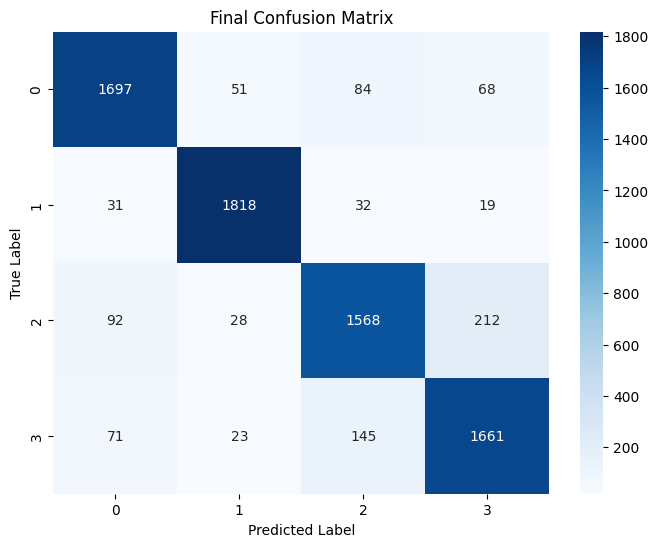

In [7]:
best_trial = study.best_trial
model = model_builder(best_trial)
model.fit([X_train_title_pad, X_train_description_pad], y_train, validation_split=0.1, epochs=5, batch_size=32, verbose=1)

# Final evaluation
y_pred = model.predict([X_test_title_pad, X_test_description_pad])
y_pred_classes = y_pred.argmax(axis=1)

final_accuracy = (y_pred_classes == y_test).mean()
print(f'Final Test Accuracy: {final_accuracy:.4f}')
print("Final Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Final Confusion Matrix')
plt.show()